write simplified mixed effects maturity model with habitats as categorical index variable 

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

,Species,Stock,Stock_Year,Age,maturity,survivorship,fecundity (num female pups per year),notes,model type,source_mat,...,linf_cm,growth_coeff_k,lmax_cm,age_max_yrs,temp_pref,nursery,depth_min,depth_max,depth_ave,param_complete
0,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,0,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
1,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,1,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
2,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,2,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
3,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,3,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
4,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,4,0.016088,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0


In [5]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 37)

In [6]:
# Sort dataframe so reef associated is the baseline category?
mdata = mdata.sort_values(by=['Species'])

In [7]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)

In [8]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [9]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
LITT = mdata.litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]

In [10]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)

In [11]:
# Index habitat types
Hab, HI = indexall(HAB)
nhabitats = len(Hab)
Hab, nhabitats

(['reef-associated',
  'demersal',
  'pelagic',
  'benthopelagic',
  'pelagic-neritic'],
 5)

In [12]:
HI

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 3, 3, 0, 4, 1, 1, 1,
       0])

In [12]:
#Indices for individual habitat types
REEF = np.array([('reef-associated' in g)*1 for g in mdata.habitat.values.astype(str)])[Sind]
DEM = np.array([('demersal' in g)*1 for g in mdata.habitat.values.astype(str)])[Sind]
PEL = np.array([('pelagic' in g)*1 for g in mdata.habitat.values.astype(str)])[Sind]
BENPEL = np.array([('benthopelagic' in g)*1 for g in mdata.habitat.values.astype(str)])[Sind]
PELNER = np.array([('pelagic-neritic' in g)*1 for g in mdata.habitat.values.astype(str)])[Sind]

In [13]:
PELNER

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [13]:
# random effects model including habitat as an index
# include limited other covariates for now
with pm.Model() as mat3:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) 
    a50_sigma = pm.Exponential('a50_sigma', 0.5) 
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) 
    # set up priors for slope values between a50 and covariates
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
   # β6 = pm.Normal('Interbirth_interval', 0, 3)
   # β7 = pm.Normal('Amax', 0, 3)
   # β8 = pm.Normal('Litter', 0, 3)
   # β9 = pm.Normal('Offspring_size', 0, 3)
   # β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
   # B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
   # B7 = pm.Normal('Amax-S', 0, 3)
   # B8 = pm.Normal('Litter-S', 0, 3)
   # B9 = pm.Normal('Offspring_size-S', 0, 3)
   # B10 = pm.Normal('Trophic-S', 0, 3)
   
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    # what data do I attach to habitat?
    mu_a50 = pm.Deterministic("mu_a50", a50 + β3*DEP + β1*LMAX + β5[HI])
    
    # Growth (S) model
   # mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    mu_S = pm.Deterministic("mu_S", S + B4*K)
        
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [14]:
# Sampling
# go back to 5000 for final run
with mat3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, K-S, Sx, S_sigma, GS, Habitat, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14989 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
pm.summary(trace3)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a50x[0],8.057,0.747,6.553,9.377,0.066,0.047,128.0,128.0,129.0,198.0,1.02
a50x[1],8.553,0.748,7.062,9.895,0.066,0.047,128.0,128.0,129.0,184.0,1.02
a50x[2],8.057,0.748,6.531,9.347,0.066,0.047,129.0,129.0,129.0,198.0,1.02
a50x[3],6.406,2.264,2.261,10.833,0.186,0.152,148.0,111.0,150.0,206.0,1.02
a50x[4],16.913,1.048,14.902,18.801,0.091,0.065,132.0,130.0,133.0,178.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
mu_S[19],6.770,0.660,5.788,7.993,0.098,0.071,45.0,44.0,66.0,240.0,1.03
mu_S[20],2.670,0.077,2.535,2.827,0.001,0.001,3511.0,3447.0,3609.0,1310.0,1.00
mu_S[21],4.412,0.174,4.070,4.727,0.005,0.003,1388.0,1363.0,1452.0,1084.0,1.00
mu_S[22],1.196,0.024,1.151,1.237,0.001,0.000,1985.0,1982.0,1989.0,1440.0,1.00


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


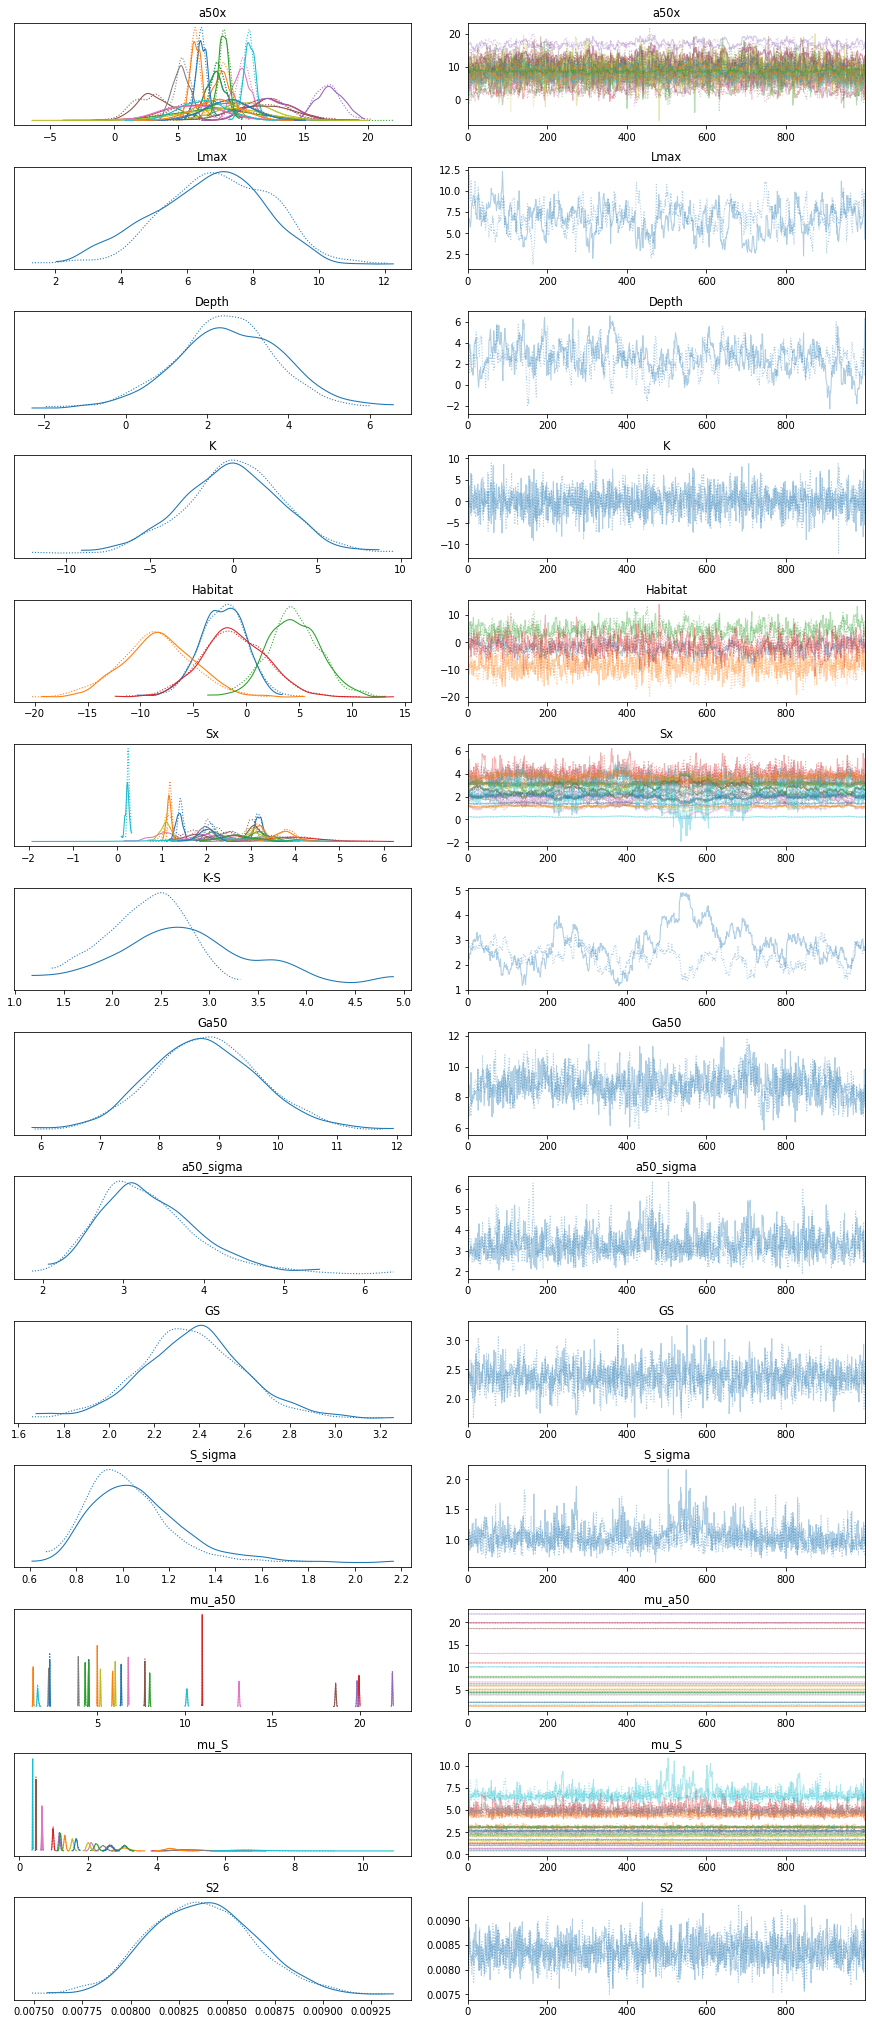

In [16]:
#check model performance
#warnings.filterwarnings("Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used", 'once')
pm.traceplot(trace3);

In [17]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace3)

'.pymc_5.trace'

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


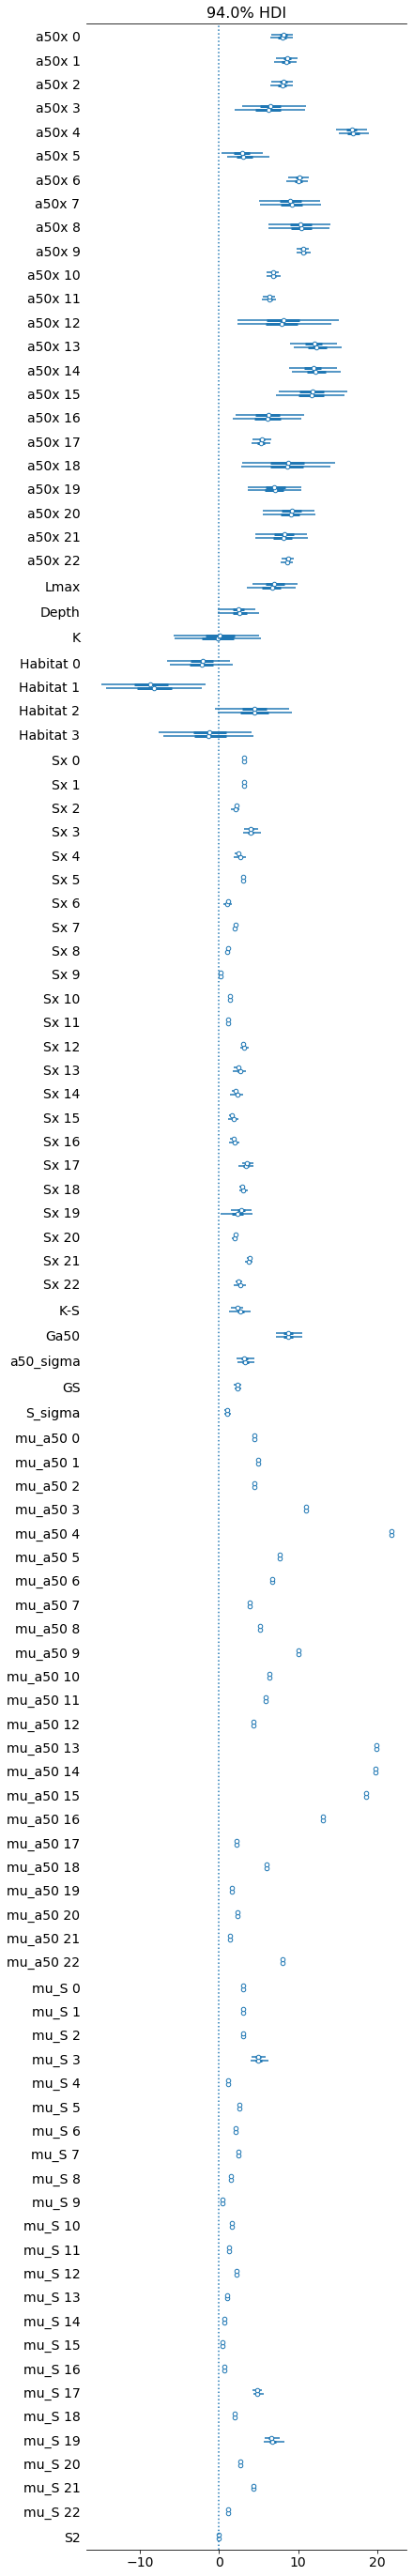

In [18]:
#forest plot for single model result
pm.forestplot(trace3)
plt.axvline(0,linestyle=':'); 

# save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mathabitat_forest.jpg',dpi=300);

## Ignore stuff below this line

In [18]:
# random effects model  including habitat as dummy variable
# include limited other covariates for now
with pm.Model() as mat4:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) 
    a50_sigma = pm.Exponential('a50_sigma', 0.5) 
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # β6 = pm.Normal('Interbirth_interval', 0, 3)
   # β7 = pm.Normal('Amax', 0, 3)
   # β8 = pm.Normal('Litter', 0, 3)
   # β9 = pm.Normal('Offspring_size', 0, 3)
   # β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    # Habitat category priors
    # Don't use reef-associated because that's the base case?
    βpn = pm.Normal('Pelagic-neritic', 0, 3)
    βd = pm.Normal('Demersal', 0,3)
    βp = pm.Normal('Pelagic', 0,3)
    βbp = pm.Normal('Benthopelagic', 0,3)    
   # bhab = pm.normal('habitat', 0, 3, shape=nhabitats) # put htis in for indexing method 

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
   # B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
   # B7 = pm.Normal('Amax-S', 0, 3)
   # B8 = pm.Normal('Litter-S', 0, 3)
   # B9 = pm.Normal('Offspring_size-S', 0, 3)
   # B10 = pm.Normal('Trophic-S', 0, 3)
   
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
   # mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β3*DEP + β4*K + βpn*PELNER + βd*DEM + βp*PEL + βbp*BENPEL)
    
    # Growth (S) model
   # mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH)
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP)
        
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [58]:
# Sampling
# go back to 5000 for final run
with mat3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Depth-S, Lmax-S, Sx, S_sigma, GS, Benthopelagic, Pelagic, Demersal, Pelagic-neritic, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42331 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718275225639462, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


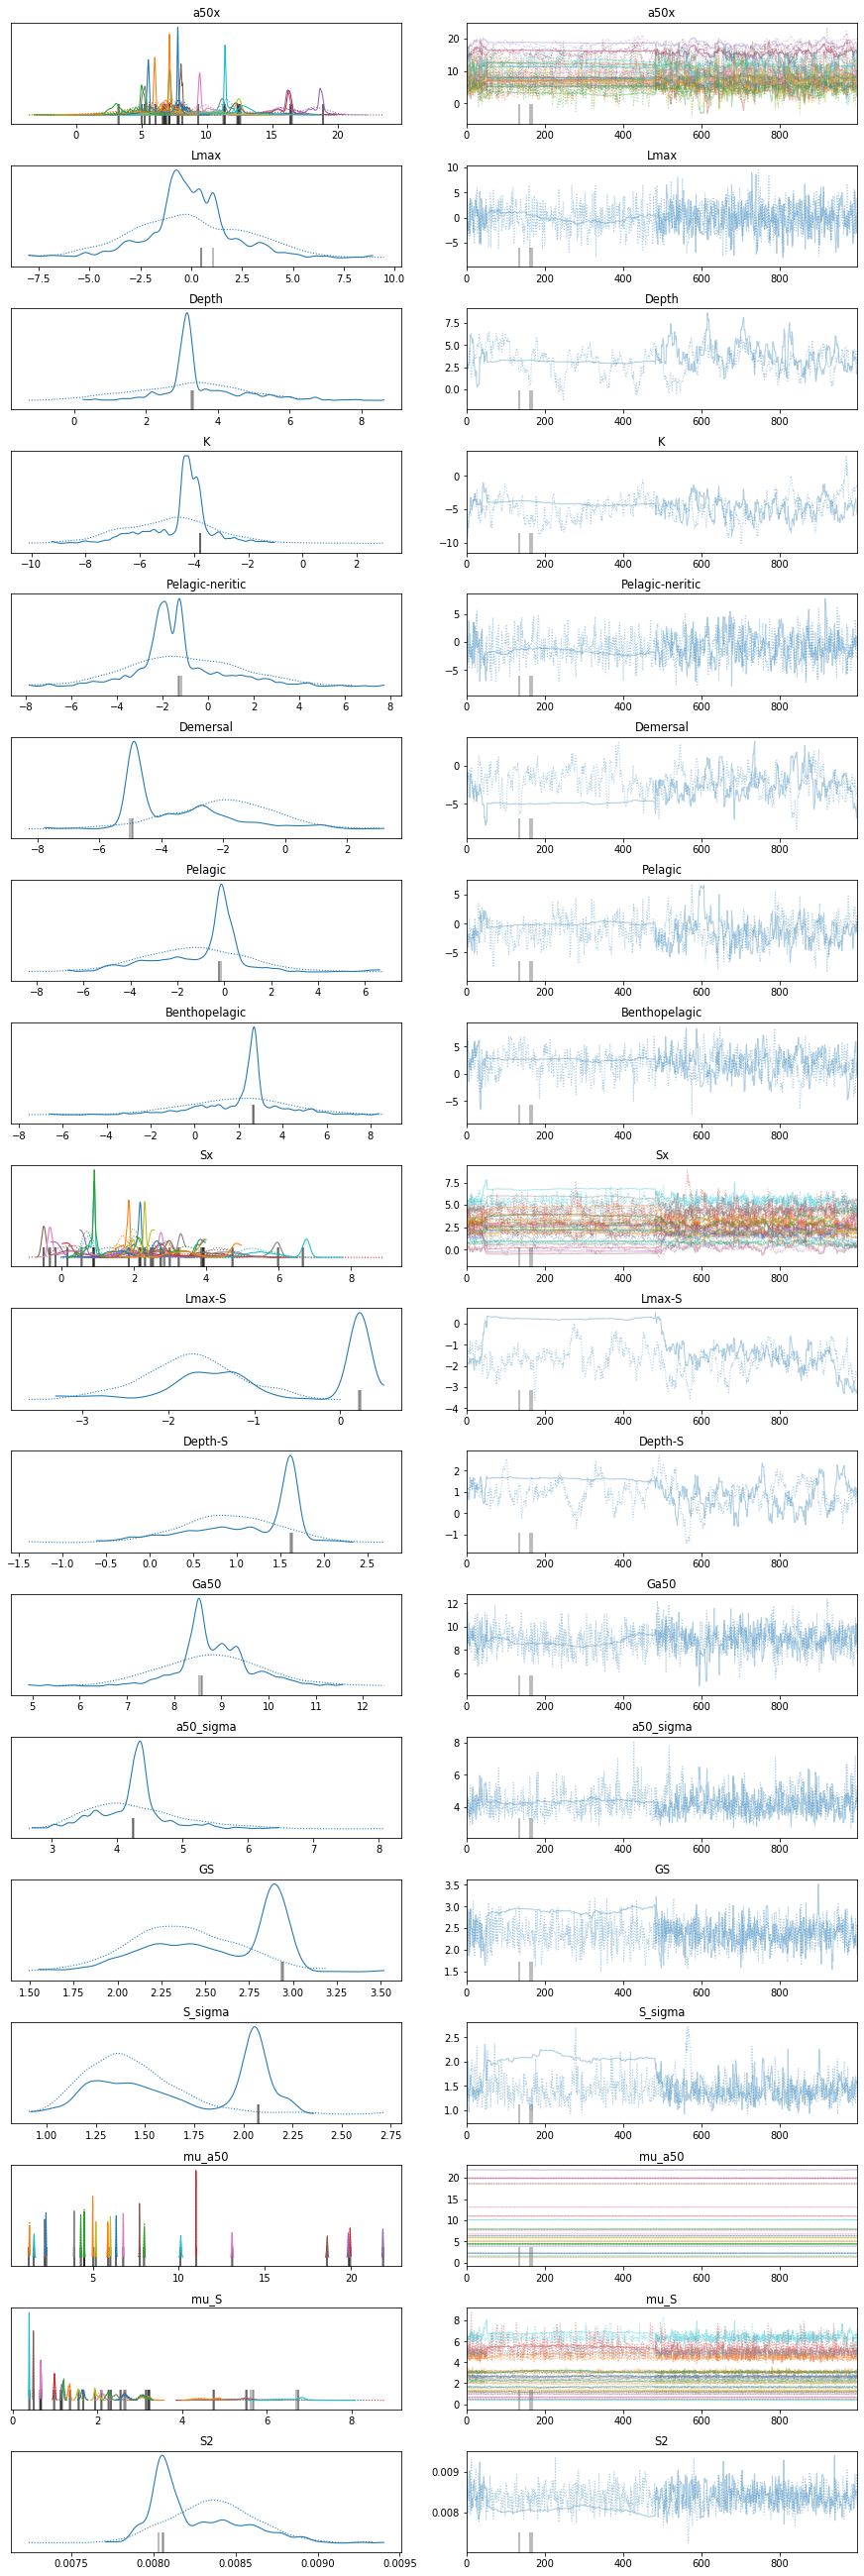

In [59]:
#check model performance
#warnings.filterwarnings("Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used", 'once')
pm.traceplot(trace3);

In [63]:
# stop huge list of warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [64]:
pm.summary(trace3)
# looking for r-hat valeus of 1 - shows that model is converging

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a50x[0],5.593,0.538,4.485,6.584,0.061,0.043,78.0,78.0,80.0,149.0,1.24
a50x[1],6.088,0.537,4.979,7.082,0.061,0.043,78.0,78.0,81.0,152.0,1.26
a50x[2],7.445,0.693,6.102,8.738,0.108,0.078,41.0,40.0,40.0,203.0,1.19
a50x[3],6.995,2.455,2.369,11.907,0.273,0.193,81.0,81.0,83.0,156.0,1.25
a50x[4],18.382,0.864,16.581,19.884,0.126,0.090,47.0,47.0,45.0,164.0,1.13
...,...,...,...,...,...,...,...,...,...,...,...
mu_S[19],6.504,0.377,5.796,7.058,0.118,0.086,10.0,10.0,11.0,743.0,1.13
mu_S[20],2.662,0.077,2.531,2.805,0.008,0.006,92.0,92.0,94.0,312.0,1.02
mu_S[21],4.519,0.225,4.172,4.917,0.103,0.078,5.0,5.0,6.0,51.0,1.26
mu_S[22],1.196,0.024,1.150,1.237,0.001,0.001,279.0,279.0,277.0,360.0,1.00


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


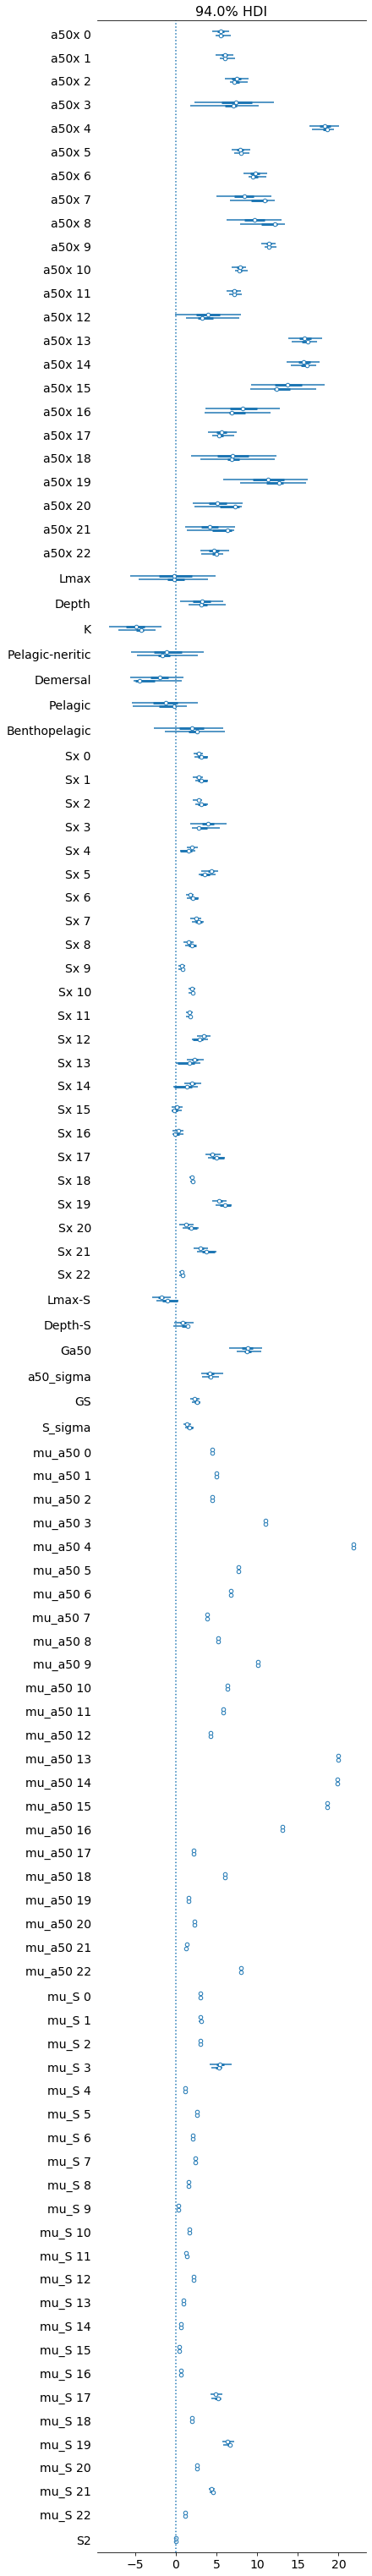

In [62]:
#forest plot for single model result
pm.forestplot(trace3)
plt.axvline(0,linestyle=':'); 

# save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('mat3_forest.jpg',dpi=300);